
# TCGA-LIHC Full Pipeline — HBV vs Non-Viral 

This notebook implements an end-to-end pipeline using:
- **Expression**: RNA-seq (STAR counts in logs)
- **Clinical (basic)**: for overall survival (OS) information
- **Xena LIHC clinicalMatrix**: to derive **HBV/HCV/NONVIRAL** from `viral_hepatitis_serology`

**Outputs** (in `outputs_lihc/`):
- `merged_dataset.tsv` (patients × genes + OS + HBV_status)
- HBV vs Non-Viral plots: `hbv_roc.png`, confusion matrices
- Feature CSVs: `hbv_top10_lr.csv`, `hbv_top10_rf.csv`
- `metrics.json`


In [ ]:

# (Optional) Install dependencies into this runtime
# %pip install pandas numpy scikit-learn matplotlib joblib


In [11]:

import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import joblib

# Optional survival
try:
    from lifelines import CoxPHFitter
    from lifelines.utils import concordance_index
    _HAS_LIFELINES = True
except Exception:
    print("[INFO] lifelines not available; survival modeling will be skipped. Install: pip install lifelines formulaic")
    _HAS_LIFELINES = False

# Helpers
def _tcga_patient_id(barcode: str) -> str:
    if pd.isna(barcode): return barcode
    return str(barcode).strip()[:12]

def _maybe_read_table(path: str) -> pd.DataFrame:
    last_err = None
    for sep in ["\t", ","]:
        try:
            df = pd.read_csv(path, sep=sep, header=0)
            if df.columns[0].lower() in {"gene","gene_id","symbol","ensembl","gene_symbol","genes"}:
                df = df.set_index(df.columns[0])
            return df
        except Exception as e:
            last_err = e
    raise ValueError(f"Could not read {path} ({last_err})")

def _align_expression(expr: pd.DataFrame) -> pd.DataFrame:
    expr = expr.apply(pd.to_numeric, errors="coerce")
    expr.columns = expr.columns.astype(str).map(_tcga_patient_id)
    return expr.groupby(level=0, axis=1).mean()

def _infer_os_columns(clin: pd.DataFrame):
    # namespaced-friendly: also match base-before-dot
    base = {}
    for c in clin.columns:
        lc = c.lower()
        base[lc] = c
        if "." in lc:
            base[lc.split(".",1)[0]] = c
    def pick(keys):
        for k in keys:
            if k in base: return base[k]
        return None
    vital = pick(["vital_status","vitalstatus","status","os_event","event"])  # required
    dth   = pick(["days_to_death","daystodeath","os_days","os.time","os_time"])
    dlf   = pick(["days_to_last_follow_up","days_to_lastfollowup","dlfu_days","days_to_last_follow_up."])
    if vital is None:
        raise ValueError("Could not infer vital status column; check headers and tweak _infer_os_columns().")
    return vital, dth, dlf

def _derive_os(clin_raw: pd.DataFrame) -> pd.DataFrame:
    vital_col, dth_col, dlf_col = _infer_os_columns(clin_raw)
    df = clin_raw.copy()
    id_col = None
    for cand in ["bcr_patient_barcode","submitter_id","patient_id","case_submitter_id","sample","sampleID","sample_id.samples"]:
        if cand in df.columns:
            id_col = cand; break
    if id_col is None:
        for c in df.columns:
            if df[c].astype(str).str.contains(r"TCGA-\w{2}-\w{4}").any():
                id_col = c; break
    if id_col is None:
        raise ValueError("No TCGA barcode column found in basic clinical file.")
    df["patient_id"] = df[id_col].astype(str).map(_tcga_patient_id)
    vc = df[vital_col].astype(str).str.lower().str.strip()
    df["OS_event"] = vc.isin(["dead","deceased","1","true","yes","event","death"]).astype(int)
    if dth_col and dlf_col:
        t = pd.to_numeric(df[dth_col], errors="coerce").fillna(pd.to_numeric(df[dlf_col], errors="coerce"))
    elif dth_col:
        t = pd.to_numeric(df[dth_col], errors="coerce")
    elif dlf_col:
        t = pd.to_numeric(df[dlf_col], errors="coerce")
    else:
        t = np.nan
    df["OS_time"] = t
    return df[["patient_id","OS_time","OS_event"]]

def _variance_filter(expr: pd.DataFrame, topk: int=2000) -> pd.DataFrame:
    var = expr.var(axis=1, skipna=True)
    return expr.loc[var.nlargest(min(topk, expr.shape[0])).index]

def _zscore_rows(expr: pd.DataFrame) -> pd.DataFrame:
    mu = expr.mean(axis=1)
    sd = expr.std(axis=1).replace(0, np.nan)
    return (expr.sub(mu, axis=0)).div(sd, axis=0).fillna(0.0)

@dataclass
class SurvivalConfig:
    topk_genes: int = 2000
    pca_components: int = 50
    penalizer: float = 0.1
    random_state: int = 42
    test_size: float = 0.2

@dataclass
class ClassifierConfig:
    topk_genes: int = 2000
    random_state: int = 42
    test_size: float = 0.2
    pos_label_horizon_days: int = 730
    C: float = 1.0
    l1_ratio: float = 0.2
    max_iter: int = 5000


## Load inputs, derive OS, and build HBV labels

In [12]:

# --- Update these paths ---
EXPR_PATH = "TCGA-LIHC.star_counts.tsv"                 # genes x samples in logs
CLIN_PATH = "TCGA-LIHC.clinical.tsv"                    # basic clinical (no viral info)
XENA_CLINMATRIX_PATH = "TCGA.LIHC.sampleMap_LIHC_clinicalMatrix"  # Xena phenotype matrix
OUTDIR = "outputs_lihc"
os.makedirs(OUTDIR, exist_ok=True)

# Load data
expr_raw   = _maybe_read_table(EXPR_PATH)
clin_basic = _maybe_read_table(CLIN_PATH)
xena_mat   = pd.read_csv(XENA_CLINMATRIX_PATH, sep="\t", index_col=0)

# Align expression to patient IDs
expr = _align_expression(expr_raw)

# Derive OS from basic clinical
clin_os = _derive_os(clin_basic)  # ['patient_id','OS_time','OS_event']

# HBV/HCV/NONVIRAL from Xena 'viral_hepatitis_serology'
if "viral_hepatitis_serology" not in xena_mat.columns:
    raise ValueError("Xena matrix lacks 'viral_hepatitis_serology' column.")
ser = xena_mat["viral_hepatitis_serology"].astype(str).str.lower()

# patient_id mapping for xena rows
if any(col for col in xena_mat.columns if "bcr_patient_barcode" in col.lower()):
    pid_col = [c for c in xena_mat.columns if "bcr_patient_barcode" in c.lower()][0]
    xena_pid = xena_mat[pid_col].astype(str).map(_tcga_patient_id)
else:
    xena_pid = pd.Index(xena_mat.index.astype(str).map(_tcga_patient_id))

hbv_mask = ser.str.contains("hepatitis b surface antigen", na=False) | ser.str.contains(r"\bhbv\b", na=False)
hcv_mask = ser.str.contains("hepatitis c", na=False) | ser.str.contains(r"\bhcv\b", na=False)

hbv_labels = pd.DataFrame({
    "patient_id": xena_pid,
    "HBV_status": pd.Series(index=xena_mat.index, dtype="object")
})
hbv_labels.loc[hbv_mask.values, "HBV_status"] = "HBV"
hbv_labels.loc[hcv_mask.values & hbv_labels["HBV_status"].isna(), "HBV_status"] = "HCV"
hbv_labels["HBV_status"] = hbv_labels["HBV_status"].fillna("NONVIRAL")

# collapse to unique patient rows
hbv_labels = (hbv_labels.dropna(subset=["patient_id"])
                          .groupby("patient_id", as_index=False)
                          .agg({"HBV_status": lambda s: s.dropna().iloc[0] if s.dropna().size else np.nan}))

print("HBV/HCV/NONVIRAL counts from Xena serology:")
print(hbv_labels["HBV_status"].value_counts(dropna=False))

# Merge OS + HBV and deduplicate
clin = clin_os.merge(hbv_labels, on="patient_id", how="outer")
agg = {
    "OS_time":  lambda s: np.nanmax(pd.to_numeric(s, errors="coerce").values) if s.notna().any() else np.nan,
    "OS_event": lambda s: int(pd.to_numeric(s, errors="coerce").fillna(0).max()),
    "HBV_status": lambda s: s.dropna().iloc[0] if s.dropna().size else np.nan,
}
clin = (clin.dropna(subset=["patient_id"])
            .groupby("patient_id", as_index=False)
            .agg(agg))

# Intersect patients
patients = sorted(set(expr.columns) & set(clin["patient_id"]))
expr = expr[patients]
clin = clin.set_index("patient_id").loc[patients].reset_index()

# Save merged TSV
merged = expr.T.copy()
for col in ["OS_time","OS_event","HBV_status"]:
    merged[col] = clin.set_index("patient_id").loc[merged.index, col]
merged_path = os.path.join(OUTDIR, "merged_dataset.tsv")
merged.to_csv(merged_path, sep="\t", index=True)

print(f"Expression shape (genes x patients): {expr.shape}")
print(f"Clinical shape: {clin.shape}")
print(f"Merged saved to: {merged_path}")
display(merged.head())


/var/folders/dn/p3xbs4r94jqf_5q7_q53zj_c0000gn/T/ipykernel_1296/2998453103.py:44: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return expr.groupby(level=0, axis=1).mean()


HBV/HCV/NONVIRAL counts from Xena serology:
HBV_status
NONVIRAL    219
HBV         147
HCV          11
Name: count, dtype: int64
Expression shape (genes x patients): (60660, 371)
Clinical shape: (371, 4)
Merged saved to: outputs_lihc/merged_dataset.tsv


,0,1,2,3,4,5,6,7,8,9,...,60653,60654,60655,60656,60657,60658,60659,OS_time,OS_event,HBV_status
TCGA-2V-A95S,11.658211,0.000000,10.082149,8.823367,7.303781,8.636625,15.964589,11.817783,12.077817,9.243174,...,0.0,0.0,0.0,7.857981,0.0,1.584963,3.807355,NaN,0,NONVIRAL
TCGA-2Y-A9GS,12.433585,0.000000,10.642052,9.182394,8.988685,7.800900,15.913380,12.083147,12.793197,10.053926,...,0.0,0.0,0.0,8.134426,0.0,3.000000,5.321928,724.0,1,HBV
TCGA-2Y-A9GT,13.140830,2.321928,9.533330,8.459432,6.149747,7.507795,16.488625,9.828136,11.358651,8.689998,...,0.0,0.0,1.0,7.707359,0.0,2.000000,4.700440,1624.0,1,HBV
TCGA-2Y-A9GU,12.389094,0.000000,10.382624,9.174926,7.228819,6.228819,16.892448,10.957102,10.783817,9.273796,...,0.0,0.0,0.0,9.126704,0.0,2.584963,1.000000,1939.0,0,HBV
TCGA-2Y-A9GV,11.694793,3.321928,9.668885,8.813781,7.965784,6.507795,15.844461,10.563196,12.050189,9.177420,...,0.0,0.0,0.0,8.033423,0.0,1.584963,4.954196,2532.0,1,HBV


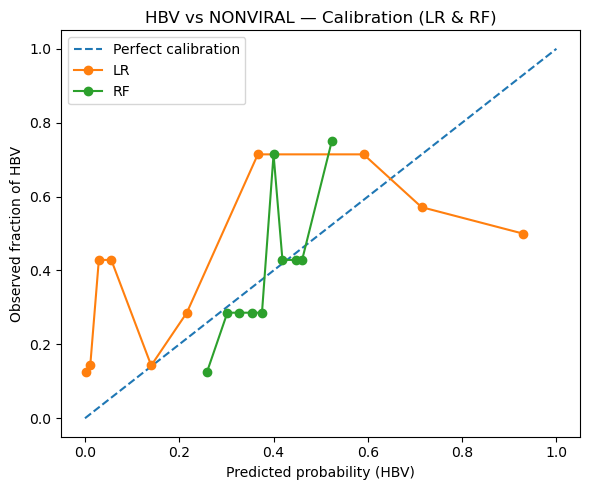

[saved] outputs_lihc/hbv_calibration_lr_rf.png
Brier score (LR): 0.2576
Brier score (RF): 0.2208


In [13]:
# === Calibration ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, roc_curve

assert 'expr' in globals() and 'clin' in globals(), "Run Step 1 first (expr/clin must exist)."
os.makedirs(OUTDIR, exist_ok=True)

# --- rebuild dataset (HBV vs NONVIRAL) ---
mask = clin["HBV_status"].isin(["HBV","NONVIRAL"])
sub = clin.loc[mask, ["patient_id","HBV_status"]].dropna()
pats = sorted(set(sub["patient_id"]) & set(expr.columns))
if len(pats) < 30 or sub["HBV_status"].nunique() < 2:
    raise RuntimeError("Not enough labeled patients. Re-check HBV mapping in Step 1.")

# feature matrix like Step 4
def _variance_filter(E, topk=2000):
    v = E.var(axis=1, skipna=True)
    return E.loc[v.nlargest(min(topk, E.shape[0])).index]
def _zscore_rows(E):
    mu = E.mean(axis=1); sd = E.std(axis=1).replace(0, np.nan)
    return (E.sub(mu, axis=0)).div(sd, axis=0).fillna(0.0)

TOPK = 2000
X_df = _zscore_rows(_variance_filter(expr[pats], topk=TOPK)).T
y = (sub.set_index("patient_id").loc[pats, "HBV_status"] == "HBV").astype(int).values

X_tr, X_te, y_tr, y_te = train_test_split(
    X_df.values, y, test_size=0.2, random_state=42, stratify=y
)

# --- train LR and RF (balanced), get probabilities ---
sc = StandardScaler()
X_tr_lr, X_te_lr = sc.fit_transform(X_tr), sc.transform(X_te)
lr = LogisticRegression(penalty="l2", solver="liblinear", class_weight="balanced",
                        max_iter=5000, random_state=42)
lr.fit(X_tr_lr, y_tr)
proba_lr = lr.predict_proba(X_te_lr)[:, 1]

rf = RandomForestClassifier(n_estimators=500, max_features="sqrt",
                            class_weight="balanced", n_jobs=-1, random_state=42)
rf.fit(X_tr, y_tr)
proba_rf = rf.predict_proba(X_te)[:, 1]

# --- calibration curves + Brier scores ---
def plot_calibration(y_true, prob_map, title, out_png):
    plt.figure(figsize=(6,5))
    xs = np.linspace(0,1,101)
    plt.plot(xs, xs, "--", label="Perfect calibration")
    for name, p in prob_map.items():
        p = np.clip(np.asarray(p).ravel(), 1e-9, 1-1e-9)
        frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=10, strategy="quantile")
        plt.plot(mean_pred, frac_pos, marker="o", linewidth=1.5, label=name)
    plt.xlabel("Predicted probability (HBV)")
    plt.ylabel("Observed fraction of HBV")
    plt.title(title)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig(out_png, dpi=160)
    plt.show()
    print(f"[saved] {out_png}")

def print_brier(y_true, prob_map):
    for name, p in prob_map.items():
        p = np.clip(np.asarray(p).ravel(), 1e-9, 1-1e-9)
        print(f"Brier score ({name}): {brier_score_loss(y_true, p):.4f}")

prob_map = {"LR": proba_lr, "RF": proba_rf}
plot_calibration(y_te, prob_map, "HBV vs NONVIRAL — Calibration (LR & RF)",
                 os.path.join(OUTDIR, "hbv_calibration_lr_rf.png"))
print_brier(y_te, prob_map)

# (Optional) also save the underlying points for the ROC/threshold sweep used earlier
fpr_lr, tpr_lr, thr_lr = roc_curve(y_te, proba_lr)
fpr_rf, tpr_rf, thr_rf = roc_curve(y_te, proba_rf)
pd.DataFrame({"fpr":fpr_lr,"tpr":tpr_lr,"thr":thr_lr}).to_csv(os.path.join(OUTDIR,"lr_roc_points.csv"), index=False)
pd.DataFrame({"fpr":fpr_rf,"tpr":tpr_rf,"thr":thr_rf}).to_csv(os.path.join(OUTDIR,"rf_roc_points.csv"), index=False)

# expose variables so the older calibration cell (if you keep it) will also work
globals().update(dict(yte=y_te, proba_lr=proba_lr, proba_rf=proba_rf))


## HBV vs Non-Viral classifiers (Logistic Regression + Random Forests)

[HBV] Labeled patients intersecting expression: 359
[HBV LR] {'auc': 0.698476343223737, 'f1': 0.5098039215686274, 'acc': 0.6527777777777778, 'cm': [[34, 9], [16, 13]]}
[HBV RF] {'auc': 0.6848436246992783, 'f1': 0.23529411764705882, 'acc': 0.6388888888888888, 'cm': [[42, 1], [25, 4]]}


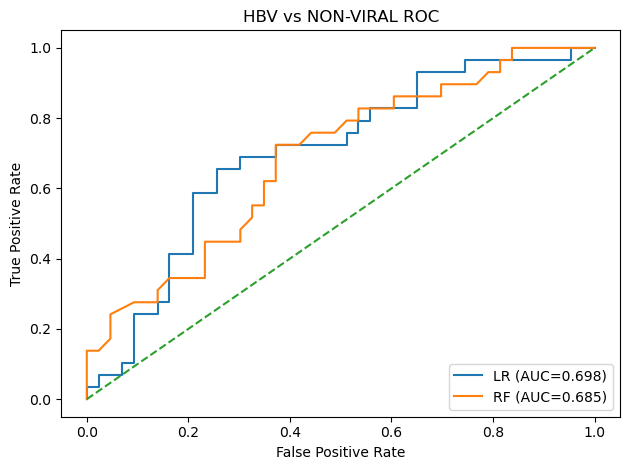

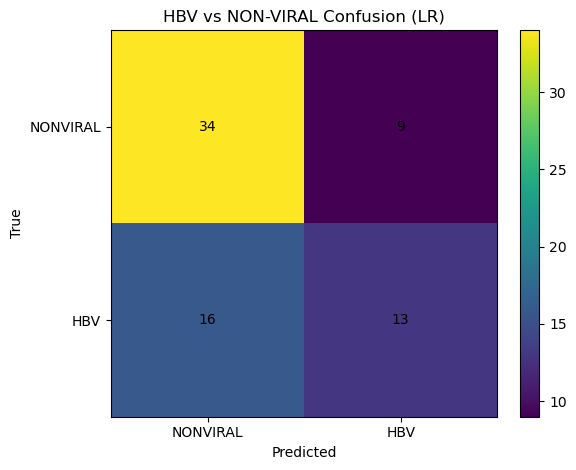

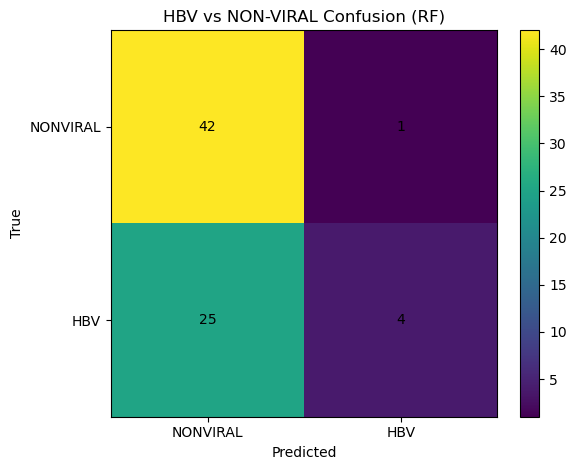

Saved metrics to outputs_lihc/metrics.json


In [11]:

mask = clin["HBV_status"].isin(["HBV","NONVIRAL"])
sub = clin.loc[mask, ["patient_id","HBV_status"]].dropna()
pats = sorted(set(sub["patient_id"]) & set(expr.columns))
print(f"[HBV] Labeled patients intersecting expression: {len(pats)}")
if len(pats) < 20 or sub["HBV_status"].nunique() < 2:
    raise ValueError("Not enough HBV/NONVIRAL labels. Verify Step 1 HBV mapping from Xena serology.")

topk = 2000
X_df = _zscore_rows(_variance_filter(expr[pats], topk=topk)).T
y = (sub.set_index("patient_id").loc[pats, "HBV_status"] == "HBV").astype(int).values

X_tr, X_te, y_tr, y_te = train_test_split(X_df.values, y, test_size=0.2, random_state=42, stratify=y if np.unique(y).size > 1 else None)

# Logistic Regression (L2)
sc_lr = StandardScaler()
X_tr_lr = sc_lr.fit_transform(X_tr); X_te_lr = sc_lr.transform(X_te)
lr = LogisticRegression(penalty="l2", solver="liblinear", class_weight="balanced", max_iter=5000, random_state=42)
lr.fit(X_tr_lr, y_tr)
proba_lr = lr.predict_proba(X_te_lr)[:,1]; preds_lr = (proba_lr >= 0.5).astype(int)

# Random Forest
rf = RandomForestClassifier(n_estimators=500, max_features="sqrt", class_weight="balanced", random_state=42, n_jobs=-1)
rf.fit(X_tr, y_tr)
proba_rf = rf.predict_proba(X_te)[:,1]; preds_rf = (proba_rf >= 0.5).astype(int)

def _metrics(p, yhat, ytrue):
    return dict(auc=float(roc_auc_score(ytrue, p)), f1=float(f1_score(ytrue, yhat)),
                acc=float(accuracy_score(ytrue, yhat)),
                cm=confusion_matrix(ytrue, yhat).tolist())

m_lr = _metrics(proba_lr, preds_lr, y_te)
m_rf = _metrics(proba_rf, preds_rf, y_te)

print("[HBV LR]", m_lr)
print("[HBV RF]", m_rf)

# ROC plot
fpr_lr, tpr_lr, _ = roc_curve(y_te, proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_te, proba_rf)
plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={m_lr['auc']:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={m_rf['auc']:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("HBV vs NON-VIRAL ROC")
plt.legend(loc="lower right"); plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "hbv_roc.png"), dpi=160)
plt.show()

# Confusion matrices
for name, cm in [("LR", m_lr["cm"]), ("RF", m_rf["cm"])]:
    plt.figure()
    arr = np.array(cm)
    im = plt.imshow(arr, interpolation="nearest")
    plt.title(f"HBV vs NON-VIRAL Confusion ({name})")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    ticks = np.arange(2)
    plt.xticks(ticks, ["NONVIRAL","HBV"]); plt.yticks(ticks, ["NONVIRAL","HBV"])
    plt.xlabel("Predicted"); plt.ylabel("True")
    for i in range(2):
        for j in range(2):
            plt.text(j, i, arr[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"hbv_confusion_{name.lower()}.png"), dpi=160)
    plt.show()

# Top-10 features
genes = X_df.columns.tolist()
coef = np.abs(lr.coef_.ravel()); idx_lr = np.argsort(coef)[-10:][::-1]
top10_lr = [(genes[i], float(coef[i])) for i in idx_lr]
imp = rf.feature_importances_; idx_rf = np.argsort(imp)[-10:][::-1]
top10_rf = [(genes[i], float(imp[i])) for i in idx_rf]

pd.DataFrame(top10_lr, columns=["gene","abs_coef"]).to_csv(os.path.join(OUTDIR, "hbv_top10_lr.csv"), index=False)
pd.DataFrame(top10_rf, columns=["gene","importance"]).to_csv(os.path.join(OUTDIR, "hbv_top10_rf.csv"), index=False)

# Save metrics
metrics = {
    "survival_c_index": None,
    "clf_auroc": None,
    "hbv_lr": m_lr, "hbv_rf": m_rf
}
try:
    if 'c_index' in locals(): metrics["survival_c_index"] = float(c_index)
    if 'auc2y' in locals():  metrics["clf_auroc"] = float(auc2y)
except: pass

with open(os.path.join(OUTDIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics to", os.path.join(OUTDIR, "metrics.json"))


In [7]:
# === Add-on: map top-10 row indices -> Ensembl IDs from the expression TSV ===
import os, pandas as pd, numpy as np, re

# 1) Read ONLY the first column of the raw expression file to get gene IDs in row order
#    (works even if your in-memory `expr` index is numeric)
expr_firstcol = pd.read_csv(EXPR_PATH, sep="\t", usecols=[0], dtype=str)
gene_col_name = expr_firstcol.columns[0]   # e.g., "Ensembl_ID"
ensembl_series = expr_firstcol.iloc[:, 0].astype(str).str.strip()

# Optional: also make a version-stripped copy (ENSG00000... without ".15", etc.)
def strip_ver(x):
    if pd.isna(x): return x
    s = str(x)
    return s.split(".")[0] if "." in s else s
ensembl_series_nover = ensembl_series.map(strip_ver)

# 2) (Optional but recommended) Fix your in-memory `expr` to use Ensembl IDs as the row index going forward
try:
    if expr.shape[0] == len(ensembl_series):
        expr = expr.copy()
        expr.index = ensembl_series.values
        print("[fix] Set expr.index to Ensembl IDs from first column of", EXPR_PATH)
    else:
        print("[warn] Row count mismatch; not resetting expr.index. Mapping will still work from CSVs.")
except NameError:
    print("[warn] `expr` not found; skipping index reset.")

# 3) Load your previously saved top-10 CSVs
rf_path = os.path.join(OUTDIR, "hbv_top10_rf.csv")
lr_path = os.path.join(OUTDIR, "hbv_top10_lr.csv")
rf_tbl = pd.read_csv(rf_path)
lr_tbl = pd.read_csv(lr_path)

# Identify the feature column (your files had 'gene' holding the row indices)
def find_feat_col(df):
    for c in df.columns:
        if c.lower() in {"gene","row_index","feature","feature_id"}:
            return c
    raise ValueError("Could not find feature/row-index column in: " + ", ".join(df.columns))

rf_feat_col = find_feat_col(rf_tbl)
lr_feat_col = find_feat_col(lr_tbl)

# Helper: map a row-index (int or string) to Ensembl ID via iloc on the first-column series
def idx_to_ensg(x):
    s = str(x).strip()
    # If it already looks like an ENSG, just return it
    if s.upper().startswith("ENSG"):
        return s
    # Else treat as row index
    try:
        i = int(float(s))  # tolerate "8553.0"
    except Exception:
        return pd.NA
    if i < 0 or i >= len(ensembl_series):
        return pd.NA
    return ensembl_series.iloc[i]

def idx_to_ensg_nover(x):
    s = str(x).strip()
    if s.upper().startswith("ENSG"):
        return strip_ver(s)
    try:
        i = int(float(s))
    except Exception:
        return pd.NA
    if i < 0 or i >= len(ensembl_series_nover):
        return pd.NA
    return ensembl_series_nover.iloc[i]

# 4) Build the mapped tables
rf_out = rf_tbl.copy()
rf_out["ENSG_ID"] = rf_out[rf_feat_col].map(idx_to_ensg)
rf_out["ENSG_ID_nover"] = rf_out[rf_feat_col].map(idx_to_ensg_nover)
# ensure consistent col order
if "importance" in rf_out.columns:
    rf_out = rf_out[["ENSG_ID","ENSG_ID_nover", rf_feat_col, "importance"]]
else:
    # fallback
    rf_out = rf_out[["ENSG_ID","ENSG_ID_nover", rf_feat_col] + [c for c in rf_out.columns if c not in {"ENSG_ID","ENSG_ID_nover", rf_feat_col}]]

lr_out = lr_tbl.copy()
lr_out["ENSG_ID"] = lr_out[lr_feat_col].map(idx_to_ensg)
lr_out["ENSG_ID_nover"] = lr_out[lr_feat_col].map(idx_to_ensg_nover)
if "abs_coef" in lr_out.columns:
    lr_out = lr_out[["ENSG_ID","ENSG_ID_nover", lr_feat_col, "abs_coef"]]
else:
    lr_out = lr_out[["ENSG_ID","ENSG_ID_nover", lr_feat_col] + [c for c in lr_out.columns if c not in {"ENSG_ID","ENSG_ID_nover", lr_feat_col}]]

# 5) Save + show
rf_mapped_path = os.path.join(OUTDIR, "hbv_top10_rf_ENSG_mapped.csv")
lr_mapped_path = os.path.join(OUTDIR, "hbv_top10_lr_ENSG_mapped.csv")
rf_out.to_csv(rf_mapped_path, index=False)
lr_out.to_csv(lr_mapped_path, index=False)

print("Saved:")
print(" -", rf_mapped_path)
print(" -", lr_mapped_path)
display(rf_out)
display(lr_out)


[fix] Set expr.index to Ensembl IDs from first column of TCGA-LIHC.star_counts.tsv
Saved:
 - outputs_lihc/hbv_top10_rf_ENSG_mapped.csv
 - outputs_lihc/hbv_top10_lr_ENSG_mapped.csv


,ENSG_ID,ENSG_ID_nover,gene,importance
0,ENSG00000144366.16,ENSG00000144366,8553,0.004043
1,ENSG00000226251.6,ENSG00000226251,26594,0.003634
2,ENSG00000162391.12,ENSG00000162391,10716,0.003111
3,ENSG00000109181.12,ENSG00000109181,3645,0.003049
4,ENSG00000282301.3,ENSG00000282301,56576,0.002804
5,ENSG00000043355.12,ENSG00000043355,597,0.002734
6,ENSG00000158874.11,ENSG00000158874,10277,0.002641
7,ENSG00000106128.19,ENSG00000106128,3265,0.002577
8,ENSG00000163071.11,ENSG00000163071,10905,0.002381
9,ENSG00000066230.12,ENSG00000066230,965,0.002318


,ENSG_ID,ENSG_ID_nover,gene,abs_coef
0,ENSG00000204764.14,ENSG00000204764,19997,0.272632
1,ENSG00000174473.16,ENSG00000174473,13698,0.229370
2,ENSG00000143194.13,ENSG00000143194,8335,0.224632
3,ENSG00000187957.8,ENSG00000187957,16584,0.223271
4,ENSG00000120659.15,ENSG00000120659,5071,0.217191
5,ENSG00000058404.20,ENSG00000058404,787,0.213625
6,ENSG00000284377.1,ENSG00000284377,57491,0.211386
7,ENSG00000043355.12,ENSG00000043355,597,0.210073
8,ENSG00000236816.3,ENSG00000236816,33768,0.207291
9,ENSG00000227097.5,ENSG00000227097,27192,0.205522


## HBV vs Non-Viral classifiers (SVM - Linear, RBF)

In [ ]:
# ======================= SVMs on gene expression only =========================
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score, f1_score, accuracy_score,
                             balanced_accuracy_score, confusion_matrix)
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone
from scipy.stats import loguniform

os.makedirs(OUTDIR, exist_ok=True)
np.random.seed(42)

# -------- helpers --------
def _variance_filter(E: pd.DataFrame, topk: int = 2000) -> pd.DataFrame:
    v = E.var(axis=1, skipna=True)
    return E.loc[v.nlargest(min(topk, E.shape[0])).index]

def _zscore_rows(E: pd.DataFrame) -> pd.DataFrame:
    mu = E.mean(axis=1); sd = E.std(axis=1).replace(0, np.nan)
    return (E.sub(mu, axis=0)).div(sd, axis=0).fillna(0.0)

# sklearn version-robust wrapper (estimator vs base_estimator)
def make_calibrated(est, method="sigmoid", cv=3, ensemble=True):
    try:
        return CalibratedClassifierCV(estimator=est, method=method, cv=cv, ensemble=ensemble)
    except TypeError:
        return CalibratedClassifierCV(base_estimator=est, method=method, cv=cv, ensemble=ensemble)

def eval_with_opt_threshold(y_true, prob):
    fpr, tpr, thr = roc_curve(y_true, prob)
    best = {"thr": 0.5, "f1": -1}
    for t in thr:
        yhat = (prob >= t).astype(int)
        f1 = f1_score(y_true, yhat)
        if f1 > best["f1"]:
            best.update({
                "thr": float(t),
                "f1": float(f1),
                "acc": float(accuracy_score(y_true, yhat)),
                "bacc": float(balanced_accuracy_score(y_true, yhat))
            })
    best["auc"] = float(roc_auc_score(y_true, prob))
    best["ap" ] = float(average_precision_score(y_true, prob))
    best["cm" ] = confusion_matrix(y_true, (prob >= best["thr"]).astype(int)).tolist()
    return best

# -------- dataset (expression only, aligned to HBV/NONVIRAL labels) --------
labels = clin.loc[:, ["patient_id","HBV_status"]].copy()
labels = labels[labels["HBV_status"].isin(["HBV","NONVIRAL"])]
pats = sorted(set(labels["patient_id"]) & set(expr.columns))
assert len(pats) >= 60, "Not enough labeled patients overlapping with expression."

TOPK = 2000
X_df = _zscore_rows(_variance_filter(expr[pats], topk=TOPK)).T
X = X_df.values
y = (labels.set_index("patient_id").loc[pats, "HBV_status"] == "HBV").astype(int).values
genes = X_df.columns.tolist()

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# -------- 1) Linear SVM (with calibration) --------
pipe_lin = Pipeline([
    ("sc", StandardScaler(with_mean=True, with_std=True)),
    ("svm", make_calibrated(
        est=LinearSVC(class_weight="balanced", random_state=42, max_iter=5000),
        method="sigmoid", cv=3
    ))
])

# simple hyperparam search over C for the base LinearSVC inside the calibrator
param_lin = {"svm__estimator__C": loguniform(1e-3, 1e2)}
try:
    rs_lin = RandomizedSearchCV(pipe_lin, param_lin, n_iter=20, scoring="roc_auc",
                                n_jobs=-1, cv=3, random_state=42, refit=True)
except Exception:
    # older sklearn keyword
    param_lin = {"svm__base_estimator__C": loguniform(1e-3, 1e2)}
    rs_lin = RandomizedSearchCV(pipe_lin, param_lin, n_iter=20, scoring="roc_auc",
                                n_jobs=-1, cv=3, random_state=42, refit=True)

rs_lin.fit(X_tr, y_tr)
proba_lin = rs_lin.predict_proba(X_te)[:, 1]
metrics_lin = eval_with_opt_threshold(y_te, proba_lin)
metrics_lin["model"] = "LinearSVM_cal"
print("[Linear SVM]", metrics_lin)

# (Optional) pseudo-feature weights: fit a plain LinearSVC(L2) on the whole train and use coefficients
lin_for_feats = LinearSVC(C=getattr(rs_lin.best_estimator_.named_steps["svm"], "estimator", 
                                    rs_lin.best_estimator_.named_steps["svm"]).C,
                          class_weight="balanced", random_state=42, max_iter=5000)
sc = StandardScaler(with_mean=True, with_std=True).fit(X_tr)
lin_for_feats.fit(sc.transform(X_tr), y_tr)
coef = lin_for_feats.coef_.ravel()
top_idx = np.argsort(np.abs(coef))[::-1][:10]
svm_linear_top10 = pd.DataFrame({
    "gene": [genes[i] for i in top_idx],
    "coef": coef[top_idx]
})
svm_linear_top10.to_csv(os.path.join(OUTDIR, "svm_linear_top10_genes.csv"), index=False)

# -------- 2) RBF SVM (non-linear) --------
pipe_rbf = Pipeline([
    ("sc", StandardScaler(with_mean=True, with_std=True)),
    ("svc", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
])
param_rbf = {"svc__C": loguniform(1e-2, 1e2), "svc__gamma": loguniform(1e-4, 1e0)}
rs_rbf = RandomizedSearchCV(pipe_rbf, param_rbf, n_iter=30, scoring="roc_auc",
                            n_jobs=-1, cv=3, random_state=42, refit=True)
rs_rbf.fit(X_tr, y_tr)
proba_rbf = rs_rbf.predict_proba(X_te)[:, 1]
metrics_rbf = eval_with_opt_threshold(y_te, proba_rbf)
metrics_rbf["model"] = "SVM_RBF"
print("[RBF SVM]", metrics_rbf)

# -------- Save metrics --------
svm_results = {"LinearSVM_cal": metrics_lin, "SVM_RBF": metrics_rbf}
with open(os.path.join(OUTDIR, "svm_results.json"), "w") as f:
    json.dump(svm_results, f, indent=2)

# -------- ROC & PR plots --------
def plot_roc_pr(y_true, prob_map, prefix):
    # ROC
    plt.figure()
    for name, p in prob_map.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        auc = roc_auc_score(y_true, p)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'--', lw=1, label="Chance")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("HBV vs NON-VIRAL — ROC (SVMs)")
    plt.legend(loc="lower right"); plt.tight_layout()
    out_roc = os.path.join(OUTDIR, f"{prefix}_roc.png")
    plt.savefig(out_roc, dpi=160); plt.show(); print("[saved]", out_roc)
    # PR
    plt.figure()
    for name, p in prob_map.items():
        prec, rec,


In [ ]:
## Plots

In [ ]:
# ================== Plot ROC & PR curves for multiple models ==================
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# prob_map = {"LR": proba_lr, "RF": proba_rf, "SVM-linear": proba_lin, "SVM-RBF": proba_rbf}
# y_true = y_te  (same test labels for all models)

def plot_roc_pr(y_true, prob_map, prefix="hbv_models"):
    # --- ROC ---
    plt.figure(figsize=(6,5))
    for name, p in prob_map.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        auc = roc_auc_score(y_true, p)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'--', lw=1, label="Chance")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("HBV vs NON-VIRAL — ROC")
    plt.legend(loc="lower right"); plt.tight_layout()
    out_roc = os.path.join(OUTDIR, f"{prefix}_roc.png")
    plt.savefig(out_roc, dpi=160); plt.show(); print("[saved]", out_roc)

    # --- PR ---
    plt.figure(figsize=(6,5))
    for name, p in prob_map.items():
        prec, rec, _ = precision_recall_curve(y_true, p)
        ap = average_precision_score(y_true, p)
        plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
    base = sum(y_true) / len(y_true)
    plt.hlines(base, 0, 1, colors="gray", linestyles="--", label="Chance (pos rate)")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("HBV vs NON-VIRAL — Precision-Recall")
    plt.legend(loc="lower left"); plt.tight_layout()
    out_pr = os.path.join(OUTDIR, f"{prefix}_pr.png")
    plt.savefig(out_pr, dpi=160); plt.show(); print("[saved]", out_pr)

# Example call:
prob_map = {"LR": proba_lr, "RF": proba_rf, "SVM-linear": proba_lin, "SVM-RBF": proba_rbf}
plot_roc_pr(y_te, prob_map, prefix="hbv_lr_rf_svm")
